# Treasure Hunt Game Notebook

### Summary
The purpose of this project is to implement an instance of a Q-learning algorithm with a specific use case of solving a maze. The AI agent must find the most efficient path through the maze in order to navigate form the beginning to the end in the least amont of steps possible. The agent may move up, down, left, or right.



In [1]:
from __future__ import print_function
import os, sys, time, datetime, json, random
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD , Adam, RMSprop
# Modified to work with Keras v2.9.0
from keras.layers import PReLU
import matplotlib.pyplot as plt
from TreasureMaze import TreasureMaze
from GameExperience import GameExperience
%matplotlib inline

Using TensorFlow backend.


The following code block contains an 8x8 matrix that will be used as a maze object:

In [2]:
maze = np.array([
    [ 1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  0.,  1.,  1.,  1.,  0.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  0.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  0.,  0.,  0.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.]
])

This helper function allows a visual representation of the maze object:

In [3]:
def show(qmaze):
    plt.grid('on')
    nrows, ncols = qmaze.maze.shape
    ax = plt.gca()
    ax.set_xticks(np.arange(0.5, nrows, 1))
    ax.set_yticks(np.arange(0.5, ncols, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    canvas = np.copy(qmaze.maze)
    for row,col in qmaze.visited:
        canvas[row,col] = 0.6
    pirate_row, pirate_col, _ = qmaze.state
    canvas[pirate_row, pirate_col] = 0.3   # pirate cell
    canvas[nrows-1, ncols-1] = 0.9 # treasure cell
    img = plt.imshow(canvas, interpolation='none', cmap='gray')
    return img

The pirate agent can move in four directions: left, right, up, and down. 

While the agent primarily learns by experience through exploitation, often, the agent can choose to explore the environment to find previously undiscovered paths. This is called "exploration" and is defined by epsilon. This value is typically a lower value such as 0.1, which means for every ten attempts, the agent will attempt to learn by experience nine times and will randomly explore a new path one time. You are encouraged to try various values for the exploration factor and see how the algorithm performs.

In [4]:
LEFT = 0
UP = 1
RIGHT = 2
DOWN = 3


# Exploration factor
epsilon = 0.1

# Actions dictionary
actions_dict = {
    LEFT: 'left',
    UP: 'up',
    RIGHT: 'right',
    DOWN: 'down',
}

num_actions = len(actions_dict)


The sample code block and output below show creating a maze object and performing one action (DOWN), which returns the reward. The resulting updated environment is visualized.

reward= -0.04


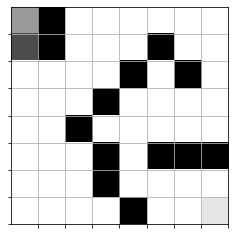

In [5]:
qmaze = TreasureMaze(maze)
canvas, reward, game_over = qmaze.act(DOWN)
print("reward=", reward)
show(qmaze)

This function simulates a full game based on the provided trained model. The other parameters include the TreasureMaze object and the starting position of the pirate.

In [6]:
def play_game(model, qmaze, pirate_cell):
    qmaze.reset(pirate_cell)
    envstate = qmaze.observe()
    while True:
        prev_envstate = envstate
        # get next action
        q = model.predict(prev_envstate)
        action = np.argmax(q[0])

        # apply action, get rewards and new state
        envstate, reward, game_status = qmaze.act(action)
        if game_status == 'win':
            return True
        elif game_status == 'lose':
            return False

This function determines whether the pirate can win any game at all. If the maze is not well designed, the pirate may not win any game at all. In this case, the training would not yield any result. The provided maze in this notebook ensures that there is a path to win and you can run this method to check.

In [7]:
def completion_check(model, qmaze):
    for cell in qmaze.free_cells:
        if not qmaze.valid_actions(cell):
            return False
        if not play_game(model, qmaze, cell):
            return False
    return True

The code you have been given in this block will build the neural network model. Review the code and note the number of layers, as well as the activation, optimizer, and loss functions that are used to train the model.

In [8]:
def build_model(maze):
    model = Sequential()
    model.add(Dense(maze.size, input_shape=(maze.size,)))
    model.add(PReLU())
    model.add(Dense(maze.size))
    model.add(PReLU())
    model.add(Dense(num_actions))
    model.compile(optimizer='adam', loss='mse')
    return model

# Implementing the Q-Training Algorithm

 The goal of the deep Q-learning implementation is to find the best possible navigation sequence that results in reaching the treasure cell while maximizing the reward. 


In [9]:
def qtrain(model, maze, **opt):

    # exploration factor
    global epsilon 

    # number of epochs
    n_epoch = opt.get('n_epoch', 15000)

    # maximum memory to store episodes
    max_memory = opt.get('max_memory', 1000)

    # maximum data size for training
    data_size = opt.get('data_size', 50)

    # start time
    start_time = datetime.datetime.now()

    # Construct environment/game from numpy array: maze (see above)
    qmaze = TreasureMaze(maze)

    # Initialize experience replay object
    experience = GameExperience(model, max_memory=max_memory)
    
    win_history = []   # history of win/lose game
    hsize = qmaze.maze.size//2   # history window size
    win_rate = 0.0
    
    # pseudocode:
    # For each epoch:
    #    Agent_cell = randomly select a free cell
    #    Reset the maze with agent set to above position
    #    Hint: Review the reset method in the TreasureMaze.py class.
    #    envstate = Environment.current_state
    #    Hint: Review the observe method in the TreasureMaze.py class.
    #    While state is not game over:
    #        previous_envstate = envstate
    #        Action = randomly choose action (left, right, up, down) either by exploration or by exploitation
    #        envstate, reward, game_status = qmaze.act(action)
    #    Hint: Review the act method in the TreasureMaze.py class.
    #        episode = [previous_envstate, action, reward, envstate, game_status]
    #        Store episode in Experience replay object
    #    Hint: Review the remember method in the GameExperience.py class.
    #        Train neural network model and evaluate loss
    #    Hint: Call GameExperience.get_data to retrieve training data (input and target) and pass to model.fit method 
    #          to train the model. You can call model.evaluate to determine loss.
    #    If the win rate is above the threshold and your model passes the completion check, that would be your epoch.


    for epoch in range(n_epoch):
        print("\n Epoch: ", epoch)
        agent_cell = np.random.randint(0, high=7, size=2)
        qmaze.reset([0,0])
        envstate = qmaze.observe()
        loss = 0
        n_episodes = 0
        
        # while game not over
        while qmaze.game_status() == 'not_over':
            previous_envstate = envstate
            valid_actions = qmaze.valid_actions()
            
            # Get action
            if np.random.rand() < epsilon:
                action = random.choice(valid_actions)
            else:
                action = np.argmax(experience.predict(envstate))
            
            # Get the state, total reward, and status
            envstate, reward, game_status = qmaze.act(action)
            n_episodes += 1
            
            episode = [previous_envstate, action, reward, envstate, game_status]
            # Store episode stats as experiecne replay object
            experience.remember(episode)                
            
            # get training data   
            inputs,targets = experience.get_data()  
            
            # train the model          
            history = model.fit(inputs, targets, epochs=8, batch_size=24, verbose=0)
            loss = model.evaluate(inputs, targets)
            
            # Update win_rate at the end of each game
            if episode[4] == 'win':
                win_history.append(1)
                win_rate = sum(win_history) / len(win_history)
                break
            elif episode[4] == 'lose':
                win_history.append(0)
                win_rate = sum(win_history) / len(win_history)
                break

    #Print the epoch, loss, episodes, win count, and win rate for each epoch
        dt = datetime.datetime.now() - start_time
        t = format_time(dt.total_seconds())
        template = "Epoch: {:03d}/{:d} | Loss: {:.4f} | Episodes: {:d} | Win count: {:d} | Win rate: {:.3f} | time: {}"
        print(template.format(epoch, n_epoch-1, loss, n_episodes, sum(win_history), win_rate, t))
        # We simply check if training has exhausted all free cells and if in all
        # cases the agent won.
        if win_rate > 0.9 : epsilon = 0.05
        if sum(win_history[-hsize:]) == hsize and completion_check(model, qmaze):
            print("Reached 100%% win rate at epoch: %d" % (epoch,))
            break
    
    
    # Determine the total time for training
    dt = datetime.datetime.now() - start_time
    seconds = dt.total_seconds()
    t = format_time(seconds)

    print("n_epoch: %d, max_mem: %d, data: %d, time: %s" % (epoch, max_memory, data_size, t))
    return seconds

# This is a small utility for printing readable time strings:
def format_time(seconds):
    if seconds < 400:
        s = float(seconds)
        return "%.1f seconds" % (s,)
    elif seconds < 4000:
        m = seconds / 60.0
        return "%.2f minutes" % (m,)
    else:
        h = seconds / 3600.0
        return "%.2f hours" % (h,)

## Testing the Model


The Cell Below Creates an Instance of the TreausureMaze class.

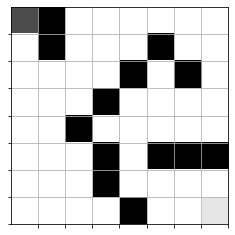

In [10]:
qmaze = TreasureMaze(maze)
show(qmaze)

The cell below builds the model and trains using Q-learning. Note: This step takes several minutes to fully run.

In [11]:
model = build_model(maze)
qtrain(model, maze, epochs=1000, max_memory=8*maze.size, data_size=32)


 Epoch:  0
10/10 [==============================] - 0s 52us/step
Epoch: 000/14999 | Loss: 0.0011 | Episodes: 140 | Win count: 0 | Win rate: 0.000 | time: 5.3 seconds

 Epoch:  1
10/10 [==============================] - 0s 104us/step


10/10 [==============================] - 0s 105us/step
Epoch: 001/14999 | Loss: 0.0005 | Episodes: 151 | Win count: 0 | Win rate: 0.000 | time: 9.7 seconds

 Epoch:  2
10/10 [==============================] - 0s 52us/step


10/10 [==============================] - 0s 52us/step
Epoch: 002/14999 | Loss: 0.0002 | Episodes: 155 | Win count: 0 | Win rate: 0.000 | time: 14.2 seconds

 Epoch:  3
10/10 [==============================] - 0s 52us/step


10/10 [==============================] - 0s 51us/step
Epoch: 003/14999 | Loss: 0.0014 | Episodes: 150 | Win count: 0 | Win rate: 0.000 | time: 18.3 seconds

 Epoch:  4
10/10 [==============================] - 0s 52us/step


10/10 [==============================] - 0s 53us/step
Epoch: 004/14999 | Loss: 0.0001 | Episodes: 99 | Win count: 1 | Win rate: 0.200 | time: 21.0 seconds

 Epoch:  5
10/10 [==============================] - 0s 53us/step


10/10 [==============================] - 0s 53us/step
Epoch: 005/14999 | Loss: 0.0001 | Episodes: 149 | Win count: 1 | Win rate: 0.167 | time: 25.4 seconds

 Epoch:  6
10/10 [==============================] - 0s 104us/step


10/10 [==============================] - 0s 52us/step
Epoch: 006/14999 | Loss: 0.0015 | Episodes: 153 | Win count: 2 | Win rate: 0.286 | time: 30.0 seconds

 Epoch:  7
10/10 [==============================] - 0s 52us/step


10/10 [==============================] - 0s 52us/step
Epoch: 007/14999 | Loss: 0.0005 | Episodes: 127 | Win count: 3 | Win rate: 0.375 | time: 33.3 seconds

 Epoch:  8
10/10 [==============================] - 0s 52us/step
Epoch: 008/14999 | Loss: 0.0017 | Episodes: 43 | Win count: 4 | Win rate: 0.444 | time: 34.6 seconds

 Epoch:  9
10/10 [==============================] - 0s 50us/step


10/10 [==============================] - 0s 52us/step
Epoch: 009/14999 | Loss: 0.0014 | Episodes: 32 | Win count: 5 | Win rate: 0.500 | time: 35.5 seconds

 Epoch:  10
10/10 [==============================] - 0s 53us/step
Epoch: 010/14999 | Loss: 0.0025 | Episodes: 46 | Win count: 6 | Win rate: 0.545 | time: 36.7 seconds

 Epoch:  11
10/10 [==============================] - 0s 52us/step
Epoch: 011/14999 | Loss: 0.0018 | Episodes: 42 | Win count: 7 | Win rate: 0.583 | time: 37.8 seconds

 Epoch:  12
10/10 [==============================] - 0s 52us/step
Epoch: 012/14999 | Loss: 0.0012 | Episodes: 49 | Win count: 8 | Win rate: 0.615 | time: 39.1 seconds

 Epoch:  13
10/10 [==============================] - 0s 52us/step


10/10 [==============================] - 0s 52us/step
Epoch: 013/14999 | Loss: 0.0011 | Episodes: 33 | Win count: 9 | Win rate: 0.643 | time: 40.0 seconds

 Epoch:  14
10/10 [==============================] - 0s 52us/step


10/10 [==============================] - 0s 52us/step
Epoch: 014/14999 | Loss: 0.0015 | Episodes: 140 | Win count: 9 | Win rate: 0.600 | time: 43.7 seconds

 Epoch:  15
10/10 [==============================] - 0s 52us/step
Epoch: 015/14999 | Loss: 0.0009 | Episodes: 28 | Win count: 10 | Win rate: 0.625 | time: 44.5 seconds

 Epoch:  16
10/10 [==============================] - 0s 105us/step


10/10 [==============================] - 0s 52us/step
Epoch: 016/14999 | Loss: 0.0022 | Episodes: 140 | Win count: 10 | Win rate: 0.588 | time: 48.3 seconds

 Epoch:  17
10/10 [==============================] - 0s 52us/step
Epoch: 017/14999 | Loss: 0.0017 | Episodes: 32 | Win count: 11 | Win rate: 0.611 | time: 49.2 seconds

 Epoch:  18
10/10 [==============================] - 0s 52us/step


10/10 [==============================] - 0s 52us/step
Epoch: 018/14999 | Loss: 0.0001 | Episodes: 139 | Win count: 11 | Win rate: 0.579 | time: 52.9 seconds

 Epoch:  19
10/10 [==============================] - 0s 52us/step
Epoch: 019/14999 | Loss: 0.0002 | Episodes: 28 | Win count: 12 | Win rate: 0.600 | time: 53.6 seconds

 Epoch:  20
10/10 [==============================] - 0s 51us/step
Epoch: 020/14999 | Loss: 0.0013 | Episodes: 40 | Win count: 13 | Win rate: 0.619 | time: 54.7 seconds

 Epoch:  21
10/10 [==============================] - 0s 52us/step


10/10 [==============================] - 0s 52us/step
Epoch: 021/14999 | Loss: 0.0014 | Episodes: 31 | Win count: 14 | Win rate: 0.636 | time: 55.5 seconds

 Epoch:  22
10/10 [==============================] - 0s 52us/step
Epoch: 022/14999 | Loss: 0.0007 | Episodes: 26 | Win count: 15 | Win rate: 0.652 | time: 56.2 seconds

 Epoch:  23
10/10 [==============================] - 0s 52us/step


10/10 [==============================] - 0s 52us/step
Epoch: 023/14999 | Loss: 0.0012 | Episodes: 141 | Win count: 15 | Win rate: 0.625 | time: 60.0 seconds

 Epoch:  24
10/10 [==============================] - 0s 52us/step
Epoch: 024/14999 | Loss: 0.0008 | Episodes: 38 | Win count: 16 | Win rate: 0.640 | time: 61.1 seconds

 Epoch:  25
10/10 [==============================] - 0s 52us/step
Epoch: 025/14999 | Loss: 0.0007 | Episodes: 30 | Win count: 17 | Win rate: 0.654 | time: 61.8 seconds

 Epoch:  26
10/10 [==============================] - 0s 52us/step
Epoch: 026/14999 | Loss: 0.0002 | Episodes: 28 | Win count: 18 | Win rate: 0.667 | time: 62.6 seconds

 Epoch:  27
10/10 [==============================] - 0s 52us/step


10/10 [==============================] - 0s 53us/step
Epoch: 027/14999 | Loss: 0.0004 | Episodes: 158 | Win count: 18 | Win rate: 0.643 | time: 66.9 seconds

 Epoch:  28
10/10 [==============================] - 0s 52us/step


10/10 [==============================] - 0s 52us/step
Epoch: 028/14999 | Loss: 0.0011 | Episodes: 34 | Win count: 19 | Win rate: 0.655 | time: 67.9 seconds

 Epoch:  29
10/10 [==============================] - 0s 51us/step
Epoch: 029/14999 | Loss: 0.0006 | Episodes: 34 | Win count: 20 | Win rate: 0.667 | time: 68.8 seconds

 Epoch:  30
10/10 [==============================] - 0s 50us/step
Epoch: 030/14999 | Loss: 0.0018 | Episodes: 30 | Win count: 21 | Win rate: 0.677 | time: 69.6 seconds

 Epoch:  31
10/10 [==============================] - 0s 52us/step
Epoch: 031/14999 | Loss: 0.0007 | Episodes: 30 | Win count: 22 | Win rate: 0.688 | time: 70.4 seconds

 Epoch:  32
10/10 [==============================] - 0s 52us/step


10/10 [==============================] - 0s 52us/step
Epoch: 032/14999 | Loss: 0.0002 | Episodes: 38 | Win count: 23 | Win rate: 0.697 | time: 71.5 seconds

 Epoch:  33
10/10 [==============================] - 0s 52us/step
Epoch: 033/14999 | Loss: 0.0005 | Episodes: 27 | Win count: 24 | Win rate: 0.706 | time: 72.3 seconds

 Epoch:  34
10/10 [==============================] - 0s 52us/step
Epoch: 034/14999 | Loss: 0.0006 | Episodes: 30 | Win count: 25 | Win rate: 0.714 | time: 73.1 seconds

 Epoch:  35
10/10 [==============================] - 0s 52us/step
Epoch: 035/14999 | Loss: 0.0018 | Episodes: 46 | Win count: 26 | Win rate: 0.722 | time: 74.4 seconds

 Epoch:  36
10/10 [==============================] - 0s 52us/step


10/10 [==============================] - 0s 52us/step
Epoch: 036/14999 | Loss: 0.0005 | Episodes: 26 | Win count: 27 | Win rate: 0.730 | time: 75.1 seconds

 Epoch:  37
10/10 [==============================] - 0s 52us/step
Epoch: 037/14999 | Loss: 0.0006 | Episodes: 72 | Win count: 28 | Win rate: 0.737 | time: 77.0 seconds

 Epoch:  38
10/10 [==============================] - 0s 53us/step
Epoch: 038/14999 | Loss: 0.0016 | Episodes: 29 | Win count: 29 | Win rate: 0.744 | time: 77.9 seconds

 Epoch:  39
10/10 [==============================] - 0s 52us/step
Epoch: 039/14999 | Loss: 0.0016 | Episodes: 36 | Win count: 30 | Win rate: 0.750 | time: 78.9 seconds

 Epoch:  40
10/10 [==============================] - 0s 52us/step


10/10 [==============================] - 0s 52us/step
Epoch: 040/14999 | Loss: 0.0005 | Episodes: 36 | Win count: 31 | Win rate: 0.756 | time: 79.8 seconds

 Epoch:  41
10/10 [==============================] - 0s 51us/step
Epoch: 041/14999 | Loss: 0.0005 | Episodes: 28 | Win count: 32 | Win rate: 0.762 | time: 80.6 seconds

 Epoch:  42
10/10 [==============================] - 0s 51us/step
Epoch: 042/14999 | Loss: 0.0004 | Episodes: 28 | Win count: 33 | Win rate: 0.767 | time: 81.4 seconds

 Epoch:  43
10/10 [==============================] - 0s 104us/step
Epoch: 043/14999 | Loss: 0.0005 | Episodes: 50 | Win count: 34 | Win rate: 0.773 | time: 82.7 seconds

 Epoch:  44
10/10 [==============================] - 0s 52us/step


10/10 [==============================] - 0s 52us/step
Epoch: 044/14999 | Loss: 0.0002 | Episodes: 70 | Win count: 35 | Win rate: 0.778 | time: 84.5 seconds

 Epoch:  45
10/10 [==============================] - 0s 106us/step
Epoch: 045/14999 | Loss: 0.0011 | Episodes: 30 | Win count: 36 | Win rate: 0.783 | time: 85.4 seconds

 Epoch:  46
10/10 [==============================] - 0s 52us/step
Epoch: 046/14999 | Loss: 0.0005 | Episodes: 34 | Win count: 37 | Win rate: 0.787 | time: 86.4 seconds

 Epoch:  47
10/10 [==============================] - 0s 52us/step


10/10 [==============================] - 0s 54us/step
Epoch: 047/14999 | Loss: 0.0014 | Episodes: 32 | Win count: 38 | Win rate: 0.792 | time: 87.3 seconds

 Epoch:  48
10/10 [==============================] - 0s 52us/step
Epoch: 048/14999 | Loss: 0.0017 | Episodes: 47 | Win count: 39 | Win rate: 0.796 | time: 88.5 seconds

 Epoch:  49
10/10 [==============================] - 0s 107us/step
Epoch: 049/14999 | Loss: 0.0009 | Episodes: 47 | Win count: 40 | Win rate: 0.800 | time: 89.8 seconds

 Epoch:  50
10/10 [==============================] - 0s 52us/step


10/10 [==============================] - 0s 52us/step
Epoch: 050/14999 | Loss: 0.0004 | Episodes: 69 | Win count: 41 | Win rate: 0.804 | time: 91.7 seconds

 Epoch:  51
10/10 [==============================] - 0s 52us/step
Epoch: 051/14999 | Loss: 0.0004 | Episodes: 24 | Win count: 42 | Win rate: 0.808 | time: 92.3 seconds

 Epoch:  52
10/10 [==============================] - 0s 52us/step
Epoch: 052/14999 | Loss: 0.0011 | Episodes: 26 | Win count: 43 | Win rate: 0.811 | time: 93.0 seconds

 Epoch:  53
10/10 [==============================] - 0s 52us/step
Epoch: 053/14999 | Loss: 0.0011 | Episodes: 34 | Win count: 44 | Win rate: 0.815 | time: 94.0 seconds

 Epoch:  54
10/10 [==============================] - 0s 53us/step


Epoch: 054/14999 | Loss: 0.0010 | Episodes: 28 | Win count: 45 | Win rate: 0.818 | time: 94.8 seconds

 Epoch:  55
10/10 [==============================] - 0s 52us/step
Epoch: 055/14999 | Loss: 0.0009 | Episodes: 64 | Win count: 46 | Win rate: 0.821 | time: 96.5 seconds

 Epoch:  56
10/10 [==============================] - 0s 52us/step
Epoch: 056/14999 | Loss: 0.0005 | Episodes: 24 | Win count: 47 | Win rate: 0.825 | time: 97.1 seconds

 Epoch:  57
10/10 [==============================] - 0s 52us/step
Epoch: 057/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 48 | Win rate: 0.828 | time: 97.9 seconds

 Epoch:  58
10/10 [==============================] - 0s 52us/step


10/10 [==============================] - 0s 52us/step
Epoch: 058/14999 | Loss: 0.0001 | Episodes: 65 | Win count: 49 | Win rate: 0.831 | time: 99.6 seconds

 Epoch:  59
10/10 [==============================] - 0s 104us/step
Epoch: 059/14999 | Loss: 0.0002 | Episodes: 42 | Win count: 50 | Win rate: 0.833 | time: 100.8 seconds

 Epoch:  60
10/10 [==============================] - 0s 52us/step
Epoch: 060/14999 | Loss: 0.0004 | Episodes: 28 | Win count: 51 | Win rate: 0.836 | time: 101.8 seconds

 Epoch:  61
10/10 [==============================] - 0s 52us/step


10/10 [==============================] - 0s 53us/step
Epoch: 061/14999 | Loss: 0.0004 | Episodes: 40 | Win count: 52 | Win rate: 0.839 | time: 103.2 seconds

 Epoch:  62
10/10 [==============================] - 0s 52us/step
Epoch: 062/14999 | Loss: 0.0008 | Episodes: 24 | Win count: 53 | Win rate: 0.841 | time: 104.3 seconds

 Epoch:  63
10/10 [==============================] - 0s 52us/step
Epoch: 063/14999 | Loss: 0.0002 | Episodes: 26 | Win count: 54 | Win rate: 0.844 | time: 105.1 seconds

 Epoch:  64
10/10 [==============================] - 0s 53us/step
Epoch: 064/14999 | Loss: 0.0018 | Episodes: 32 | Win count: 55 | Win rate: 0.846 | time: 106.3 seconds

 Epoch:  65
10/10 [==============================] - 0s 52us/step
Epoch: 065/14999 | Loss: 0.0002 | Episodes: 26 | Win count: 56 | Win rate: 0.848 | time: 107.0 seconds

 Epoch:  66
10/10 [==============================] - 0s 52us/step


10/10 [==============================] - 0s 52us/step
Epoch: 066/14999 | Loss: 0.0005 | Episodes: 46 | Win count: 57 | Win rate: 0.851 | time: 108.5 seconds

 Epoch:  67
10/10 [==============================] - 0s 52us/step
Epoch: 067/14999 | Loss: 0.0002 | Episodes: 40 | Win count: 58 | Win rate: 0.853 | time: 109.9 seconds

 Epoch:  68
10/10 [==============================] - 0s 52us/step
Epoch: 068/14999 | Loss: 0.0002 | Episodes: 39 | Win count: 59 | Win rate: 0.855 | time: 111.1 seconds

 Epoch:  69
10/10 [==============================] - 0s 52us/step
Epoch: 069/14999 | Loss: 0.0008 | Episodes: 30 | Win count: 60 | Win rate: 0.857 | time: 112.1 seconds

 Epoch:  70
10/10 [==============================] - 0s 103us/step


10/10 [==============================] - 0s 52us/step
Epoch: 070/14999 | Loss: 0.0011 | Episodes: 42 | Win count: 61 | Win rate: 0.859 | time: 113.6 seconds

 Epoch:  71
10/10 [==============================] - 0s 52us/step
Epoch: 071/14999 | Loss: 0.0014 | Episodes: 32 | Win count: 62 | Win rate: 0.861 | time: 114.5 seconds

 Epoch:  72
10/10 [==============================] - 0s 52us/step
Epoch: 072/14999 | Loss: 0.0010 | Episodes: 38 | Win count: 63 | Win rate: 0.863 | time: 115.8 seconds

 Epoch:  73
10/10 [==============================] - 0s 104us/step
Epoch: 073/14999 | Loss: 0.0012 | Episodes: 26 | Win count: 64 | Win rate: 0.865 | time: 116.8 seconds

 Epoch:  74
10/10 [==============================] - 0s 52us/step


10/10 [==============================] - 0s 52us/step
Epoch: 074/14999 | Loss: 0.0006 | Episodes: 73 | Win count: 65 | Win rate: 0.867 | time: 118.8 seconds

 Epoch:  75
10/10 [==============================] - 0s 52us/step
Epoch: 075/14999 | Loss: 0.0021 | Episodes: 34 | Win count: 66 | Win rate: 0.868 | time: 120.0 seconds

 Epoch:  76
10/10 [==============================] - 0s 52us/step
Epoch: 076/14999 | Loss: 0.0011 | Episodes: 32 | Win count: 67 | Win rate: 0.870 | time: 121.1 seconds

 Epoch:  77
10/10 [==============================] - 0s 52us/step
Epoch: 077/14999 | Loss: 0.0008 | Episodes: 30 | Win count: 68 | Win rate: 0.872 | time: 122.1 seconds



 Epoch:  78
10/10 [==============================] - 0s 52us/step
Epoch: 078/14999 | Loss: 0.0007 | Episodes: 28 | Win count: 69 | Win rate: 0.873 | time: 123.1 seconds

 Epoch:  79
10/10 [==============================] - 0s 52us/step
Epoch: 079/14999 | Loss: 0.0013 | Episodes: 50 | Win count: 70 | Win rate: 0.875 | time: 124.6 seconds

 Epoch:  80
10/10 [==============================] - 0s 52us/step
Epoch: 080/14999 | Loss: 0.0012 | Episodes: 31 | Win count: 71 | Win rate: 0.877 | time: 125.8 seconds

 Epoch:  81
10/10 [==============================] - 0s 53us/step
Epoch: 081/14999 | Loss: 0.0001 | Episodes: 30 | Win count: 72 | Win rate: 0.878 | time: 126.8 seconds

 Epoch:  82
10/10 [==============================] - 0s 52us/step


10/10 [==============================] - 0s 52us/step
Epoch: 082/14999 | Loss: 0.0012 | Episodes: 34 | Win count: 73 | Win rate: 0.880 | time: 128.0 seconds

 Epoch:  83
10/10 [==============================] - 0s 52us/step
Epoch: 083/14999 | Loss: 0.0019 | Episodes: 34 | Win count: 74 | Win rate: 0.881 | time: 129.0 seconds

 Epoch:  84
10/10 [==============================] - 0s 53us/step
Epoch: 084/14999 | Loss: 0.0008 | Episodes: 30 | Win count: 75 | Win rate: 0.882 | time: 129.9 seconds

 Epoch:  85
10/10 [==============================] - 0s 56us/step


Epoch: 085/14999 | Loss: 0.0006 | Episodes: 52 | Win count: 76 | Win rate: 0.884 | time: 131.6 seconds

 Epoch:  86
10/10 [==============================] - 0s 52us/step
Epoch: 086/14999 | Loss: 0.0010 | Episodes: 30 | Win count: 77 | Win rate: 0.885 | time: 132.6 seconds

 Epoch:  87
10/10 [==============================] - 0s 50us/step
Epoch: 087/14999 | Loss: 0.0010 | Episodes: 38 | Win count: 78 | Win rate: 0.886 | time: 133.9 seconds

 Epoch:  88
10/10 [==============================] - 0s 52us/step
Epoch: 088/14999 | Loss: 0.0001 | Episodes: 30 | Win count: 79 | Win rate: 0.888 | time: 134.9 seconds

 Epoch:  89
10/10 [==============================] - 0s 53us/step
Epoch: 089/14999 | Loss: 0.0016 | Episodes: 34 | Win count: 80 | Win rate: 0.889 | time: 136.0 seconds

 Epoch:  90
10/10 [==============================] - 0s 105us/step


10/10 [==============================] - 0s 52us/step
Epoch: 090/14999 | Loss: 0.0006 | Episodes: 36 | Win count: 81 | Win rate: 0.890 | time: 137.3 seconds

 Epoch:  91
10/10 [==============================] - 0s 52us/step
Epoch: 091/14999 | Loss: 0.0002 | Episodes: 44 | Win count: 82 | Win rate: 0.891 | time: 138.9 seconds

 Epoch:  92
10/10 [==============================] - 0s 52us/step
Epoch: 092/14999 | Loss: 0.0009 | Episodes: 32 | Win count: 83 | Win rate: 0.892 | time: 140.0 seconds

 Epoch:  93
10/10 [==============================] - 0s 52us/step
Epoch: 093/14999 | Loss: 0.0013 | Episodes: 26 | Win count: 84 | Win rate: 0.894 | time: 141.1 seconds

 Epoch:  94
10/10 [==============================] - 0s 52us/step


10/10 [==============================] - 0s 52us/step
Epoch: 094/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 85 | Win rate: 0.895 | time: 142.3 seconds

 Epoch:  95
10/10 [==============================] - 0s 53us/step
Epoch: 095/14999 | Loss: 0.0003 | Episodes: 28 | Win count: 86 | Win rate: 0.896 | time: 143.3 seconds

 Epoch:  96
10/10 [==============================] - 0s 104us/step
Epoch: 096/14999 | Loss: 0.0015 | Episodes: 30 | Win count: 87 | Win rate: 0.897 | time: 144.5 seconds

 Epoch:  97
10/10 [==============================] - 0s 51us/step
Epoch: 097/14999 | Loss: 0.0013 | Episodes: 27 | Win count: 88 | Win rate: 0.898 | time: 145.4 seconds

 Epoch:  98
10/10 [==============================] - 0s 52us/step
Epoch: 098/14999 | Loss: 0.0009 | Episodes: 30 | Win count: 89 | Win rate: 0.899 | time: 146.3 seconds

 Epoch:  99
10/10 [==============================] - 0s 54us/step


10/10 [==============================] - 0s 52us/step
Epoch: 099/14999 | Loss: 0.0012 | Episodes: 56 | Win count: 90 | Win rate: 0.900 | time: 147.9 seconds

 Epoch:  100
10/10 [==============================] - 0s 52us/step
Epoch: 100/14999 | Loss: 0.0005 | Episodes: 26 | Win count: 91 | Win rate: 0.901 | time: 148.7 seconds

 Epoch:  101
10/10 [==============================] - 0s 52us/step
Epoch: 101/14999 | Loss: 0.0002 | Episodes: 30 | Win count: 92 | Win rate: 0.902 | time: 149.8 seconds

 Epoch:  102
10/10 [==============================] - 0s 52us/step
Epoch: 102/14999 | Loss: 0.0010 | Episodes: 34 | Win count: 93 | Win rate: 0.903 | time: 150.8 seconds

 Epoch:  103
10/10 [==============================] - 0s 52us/step


10/10 [==============================] - 0s 52us/step
Epoch: 103/14999 | Loss: 0.0001 | Episodes: 27 | Win count: 94 | Win rate: 0.904 | time: 151.7 seconds

 Epoch:  104
10/10 [==============================] - 0s 52us/step
Epoch: 104/14999 | Loss: 0.0003 | Episodes: 32 | Win count: 95 | Win rate: 0.905 | time: 152.8 seconds

 Epoch:  105
10/10 [==============================] - 0s 52us/step
Epoch: 105/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 96 | Win rate: 0.906 | time: 153.7 seconds

 Epoch:  106
10/10 [==============================] - 0s 52us/step
Epoch: 106/14999 | Loss: 0.0001 | Episodes: 42 | Win count: 97 | Win rate: 0.907 | time: 154.9 seconds

 Epoch:  107
10/10 [==============================] - 0s 52us/step


10/10 [==============================] - 0s 52us/step
Epoch: 107/14999 | Loss: 0.0013 | Episodes: 43 | Win count: 98 | Win rate: 0.907 | time: 156.3 seconds

 Epoch:  108
10/10 [==============================] - 0s 52us/step
Epoch: 108/14999 | Loss: 0.0002 | Episodes: 61 | Win count: 99 | Win rate: 0.908 | time: 158.0 seconds

 Epoch:  109
10/10 [==============================] - 0s 52us/step
Epoch: 109/14999 | Loss: 0.0016 | Episodes: 34 | Win count: 100 | Win rate: 0.909 | time: 159.0 seconds

 Epoch:  110
10/10 [==============================] - 0s 52us/step
Epoch: 110/14999 | Loss: 0.0002 | Episodes: 26 | Win count: 101 | Win rate: 0.910 | time: 159.8 seconds

 Epoch:  111
10/10 [==============================] - 0s 52us/step


10/10 [==============================] - 0s 53us/step
Epoch: 111/14999 | Loss: 0.0010 | Episodes: 34 | Win count: 102 | Win rate: 0.911 | time: 161.0 seconds

 Epoch:  112
10/10 [==============================] - 0s 52us/step
Epoch: 112/14999 | Loss: 0.0006 | Episodes: 26 | Win count: 103 | Win rate: 0.912 | time: 161.9 seconds

 Epoch:  113
10/10 [==============================] - 0s 53us/step
Epoch: 113/14999 | Loss: 0.0012 | Episodes: 72 | Win count: 104 | Win rate: 0.912 | time: 163.9 seconds

 Epoch:  114
10/10 [==============================] - 0s 53us/step


10/10 [==============================] - 0s 52us/step
Epoch: 114/14999 | Loss: 0.0002 | Episodes: 36 | Win count: 105 | Win rate: 0.913 | time: 164.9 seconds

 Epoch:  115
10/10 [==============================] - 0s 104us/step
Epoch: 115/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 106 | Win rate: 0.914 | time: 165.8 seconds

 Epoch:  116
10/10 [==============================] - 0s 53us/step
Epoch: 116/14999 | Loss: 0.0001 | Episodes: 34 | Win count: 107 | Win rate: 0.915 | time: 166.9 seconds

 Epoch:  117
10/10 [==============================] - 0s 53us/step
Epoch: 117/14999 | Loss: 0.0002 | Episodes: 26 | Win count: 108 | Win rate: 0.915 | time: 167.9 seconds

 Epoch:  118
10/10 [==============================] - 0s 53us/step
Epoch: 118/14999 | Loss: 0.0000 | Episodes: 36 | Win count: 109 | Win rate: 0.916 | time: 169.1 seconds



 Epoch:  119
10/10 [==============================] - 0s 52us/step
Epoch: 119/14999 | Loss: 0.0002 | Episodes: 26 | Win count: 110 | Win rate: 0.917 | time: 170.3 seconds

 Epoch:  120
10/10 [==============================] - 0s 52us/step
Epoch: 120/14999 | Loss: 0.0013 | Episodes: 28 | Win count: 111 | Win rate: 0.917 | time: 171.5 seconds

 Epoch:  121
10/10 [==============================] - 0s 50us/step
Epoch: 121/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 112 | Win rate: 0.918 | time: 172.5 seconds

 Epoch:  122
10/10 [==============================] - 0s 105us/step
Epoch: 122/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 113 | Win rate: 0.919 | time: 173.5 seconds

 Epoch:  123
10/10 [==============================] - 0s 156us/step
Epoch: 123/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 114 | Win rate: 0.919 | time: 174.4 seconds

 Epoch:  124
10/10 [==============================] - 0s 104us/step


10/10 [==============================] - 0s 52us/step
Epoch: 124/14999 | Loss: 0.0000 | Episodes: 36 | Win count: 115 | Win rate: 0.920 | time: 175.6 seconds

 Epoch:  125
10/10 [==============================] - 0s 52us/step
Epoch: 125/14999 | Loss: 0.0000 | Episodes: 32 | Win count: 116 | Win rate: 0.921 | time: 176.7 seconds

 Epoch:  126
10/10 [==============================] - 0s 52us/step
Epoch: 126/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 117 | Win rate: 0.921 | time: 177.6 seconds

 Epoch:  127
10/10 [==============================] - 0s 53us/step
Epoch: 127/14999 | Loss: 0.0003 | Episodes: 32 | Win count: 118 | Win rate: 0.922 | time: 178.7 seconds

 Epoch:  128
10/10 [==============================] - 0s 52us/step
Epoch: 128/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 119 | Win rate: 0.922 | time: 179.7 seconds



 Epoch:  129
10/10 [==============================] - 0s 52us/step
Epoch: 129/14999 | Loss: 0.0000 | Episodes: 50 | Win count: 120 | Win rate: 0.923 | time: 181.3 seconds

 Epoch:  130
10/10 [==============================] - 0s 52us/step
Epoch: 130/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 121 | Win rate: 0.924 | time: 182.2 seconds

 Epoch:  131
10/10 [==============================] - 0s 52us/step
Epoch: 131/14999 | Loss: 0.0000 | Episodes: 36 | Win count: 122 | Win rate: 0.924 | time: 183.6 seconds

 Epoch:  132
10/10 [==============================] - 0s 52us/step


10/10 [==============================] - 0s 53us/step
Epoch: 132/14999 | Loss: 0.0001 | Episodes: 40 | Win count: 123 | Win rate: 0.925 | time: 184.9 seconds

 Epoch:  133
10/10 [==============================] - 0s 52us/step
Epoch: 133/14999 | Loss: 0.0001 | Episodes: 38 | Win count: 124 | Win rate: 0.925 | time: 186.0 seconds

 Epoch:  134
10/10 [==============================] - 0s 52us/step
Epoch: 134/14999 | Loss: 0.0000 | Episodes: 41 | Win count: 125 | Win rate: 0.926 | time: 187.2 seconds

 Epoch:  135
10/10 [==============================] - 0s 52us/step
Epoch: 135/14999 | Loss: 0.0001 | Episodes: 36 | Win count: 126 | Win rate: 0.926 | time: 188.4 seconds

 Epoch:  136
10/10 [==============================] - 0s 52us/step


10/10 [==============================] - 0s 54us/step
Epoch: 136/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 127 | Win rate: 0.927 | time: 189.5 seconds

 Epoch:  137
10/10 [==============================] - 0s 52us/step
Epoch: 137/14999 | Loss: 0.0002 | Episodes: 30 | Win count: 128 | Win rate: 0.928 | time: 190.5 seconds

 Epoch:  138
10/10 [==============================] - 0s 52us/step
Epoch: 138/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 129 | Win rate: 0.928 | time: 191.4 seconds

 Epoch:  139
10/10 [==============================] - 0s 52us/step
Epoch: 139/14999 | Loss: 0.0000 | Episodes: 32 | Win count: 130 | Win rate: 0.929 | time: 192.5 seconds

 Epoch:  140
10/10 [==============================] - 0s 52us/step
Epoch: 140/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 131 | Win rate: 0.929 | time: 193.3 seconds

 Epoch:  141
10/10 [==============================] - 0s 52us/step


10/10 [==============================] - 0s 52us/step
Epoch: 141/14999 | Loss: 0.0009 | Episodes: 24 | Win count: 132 | Win rate: 0.930 | time: 194.2 seconds

 Epoch:  142
10/10 [==============================] - 0s 52us/step
Epoch: 142/14999 | Loss: 0.0000 | Episodes: 36 | Win count: 133 | Win rate: 0.930 | time: 195.5 seconds

 Epoch:  143
10/10 [==============================] - 0s 52us/step
Epoch: 143/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 134 | Win rate: 0.931 | time: 196.6 seconds

 Epoch:  144
10/10 [==============================] - 0s 52us/step
Epoch: 144/14999 | Loss: 0.0001 | Episodes: 25 | Win count: 135 | Win rate: 0.931 | time: 197.6 seconds

 Epoch:  145
10/10 [==============================] - 0s 52us/step
Epoch: 145/14999 | Loss: 0.0009 | Episodes: 24 | Win count: 136 | Win rate: 0.932 | time: 198.6 seconds

 Epoch:  146
10/10 [==============================] - 0s 52us/step
Epoch: 146/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 137 | Win rate: 0.932 | ti

10/10 [==============================] - 0s 53us/step
Epoch: 147/14999 | Loss: 0.0000 | Episodes: 36 | Win count: 138 | Win rate: 0.932 | time: 201.0 seconds

 Epoch:  148
10/10 [==============================] - 0s 53us/step
Epoch: 148/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 139 | Win rate: 0.933 | time: 202.1 seconds

 Epoch:  149
10/10 [==============================] - 0s 53us/step
Epoch: 149/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 140 | Win rate: 0.933 | time: 203.1 seconds

 Epoch:  150
10/10 [==============================] - 0s 52us/step
Epoch: 150/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 141 | Win rate: 0.934 | time: 204.0 seconds

 Epoch:  151
10/10 [==============================] - 0s 52us/step
Epoch: 151/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 142 | Win rate: 0.934 | time: 205.1 seconds

 Epoch:  152
10/10 [==============================] - 0s 52us/step


10/10 [==============================] - 0s 0us/step
Epoch: 152/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 143 | Win rate: 0.935 | time: 206.1 seconds

 Epoch:  153
10/10 [==============================] - 0s 52us/step
Epoch: 153/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 144 | Win rate: 0.935 | time: 207.0 seconds

 Epoch:  154
10/10 [==============================] - 0s 52us/step
Epoch: 154/14999 | Loss: 0.0002 | Episodes: 24 | Win count: 145 | Win rate: 0.935 | time: 208.0 seconds

 Epoch:  155
10/10 [==============================] - 0s 52us/step
Epoch: 155/14999 | Loss: 0.0008 | Episodes: 24 | Win count: 146 | Win rate: 0.936 | time: 209.0 seconds

 Epoch:  156
10/10 [==============================] - 0s 103us/step
Epoch: 156/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 147 | Win rate: 0.936 | time: 210.0 seconds

 Epoch:  157
10/10 [==============================] - 0s 52us/step
Epoch: 157/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 148 | Win rate: 0.937 | ti

10/10 [==============================] - 0s 52us/step
Epoch: 158/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 149 | Win rate: 0.937 | time: 211.8 seconds

 Epoch:  159
10/10 [==============================] - 0s 52us/step
Epoch: 159/14999 | Loss: 0.0000 | Episodes: 38 | Win count: 150 | Win rate: 0.938 | time: 213.1 seconds

 Epoch:  160
10/10 [==============================] - 0s 52us/step
Epoch: 160/14999 | Loss: 0.0003 | Episodes: 32 | Win count: 151 | Win rate: 0.938 | time: 214.2 seconds

 Epoch:  161
10/10 [==============================] - 0s 52us/step
Epoch: 161/14999 | Loss: 0.0000 | Episodes: 38 | Win count: 152 | Win rate: 0.938 | time: 215.7 seconds

 Epoch:  162
10/10 [==============================] - 0s 53us/step


10/10 [==============================] - 0s 53us/step
Epoch: 162/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 153 | Win rate: 0.939 | time: 216.7 seconds

 Epoch:  163
10/10 [==============================] - 0s 52us/step
Epoch: 163/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 154 | Win rate: 0.939 | time: 217.7 seconds

 Epoch:  164
10/10 [==============================] - 0s 52us/step
Epoch: 164/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 155 | Win rate: 0.939 | time: 218.8 seconds

 Epoch:  165
10/10 [==============================] - 0s 52us/step
Epoch: 165/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 156 | Win rate: 0.940 | time: 219.8 seconds

 Epoch:  166
10/10 [==============================] - 0s 52us/step
Epoch: 166/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 157 | Win rate: 0.940 | time: 220.9 seconds

 Epoch:  167
10/10 [==============================] - 0s 52us/step
Epoch: 167/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 158 | Win rate: 0.940 | ti

10/10 [==============================] - 0s 52us/step
Epoch: 168/14999 | Loss: 0.0000 | Episodes: 40 | Win count: 159 | Win rate: 0.941 | time: 223.2 seconds

 Epoch:  169
10/10 [==============================] - 0s 52us/step
Epoch: 169/14999 | Loss: 0.0001 | Episodes: 36 | Win count: 160 | Win rate: 0.941 | time: 224.5 seconds

 Epoch:  170
10/10 [==============================] - 0s 52us/step
Epoch: 170/14999 | Loss: 0.0001 | Episodes: 40 | Win count: 161 | Win rate: 0.942 | time: 225.8 seconds

 Epoch:  171
10/10 [==============================] - 0s 52us/step
Epoch: 171/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 162 | Win rate: 0.942 | time: 226.7 seconds

 Epoch:  172
10/10 [==============================] - 0s 51us/step


10/10 [==============================] - 0s 52us/step
Epoch: 172/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 163 | Win rate: 0.942 | time: 227.9 seconds

 Epoch:  173
10/10 [==============================] - 0s 52us/step
Epoch: 173/14999 | Loss: 0.0001 | Episodes: 36 | Win count: 164 | Win rate: 0.943 | time: 229.2 seconds

 Epoch:  174
10/10 [==============================] - 0s 52us/step
Epoch: 174/14999 | Loss: 0.0010 | Episodes: 46 | Win count: 165 | Win rate: 0.943 | time: 230.6 seconds

 Epoch:  175
10/10 [==============================] - 0s 52us/step
Epoch: 175/14999 | Loss: 0.0009 | Episodes: 31 | Win count: 166 | Win rate: 0.943 | time: 231.6 seconds

 Epoch:  176
10/10 [==============================] - 0s 52us/step


10/10 [==============================] - 0s 105us/step
Epoch: 176/14999 | Loss: 0.0009 | Episodes: 35 | Win count: 167 | Win rate: 0.944 | time: 232.7 seconds

 Epoch:  177
10/10 [==============================] - 0s 52us/step
Epoch: 177/14999 | Loss: 0.0013 | Episodes: 58 | Win count: 168 | Win rate: 0.944 | time: 234.3 seconds

 Epoch:  178
10/10 [==============================] - 0s 52us/step
Epoch: 178/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 169 | Win rate: 0.944 | time: 235.1 seconds

 Epoch:  179
10/10 [==============================] - 0s 52us/step
Epoch: 179/14999 | Loss: 0.0001 | Episodes: 30 | Win count: 170 | Win rate: 0.944 | time: 236.3 seconds



 Epoch:  180
10/10 [==============================] - 0s 51us/step
Epoch: 180/14999 | Loss: 0.0004 | Episodes: 26 | Win count: 171 | Win rate: 0.945 | time: 237.2 seconds

 Epoch:  181
10/10 [==============================] - 0s 52us/step
Epoch: 181/14999 | Loss: 0.0000 | Episodes: 38 | Win count: 172 | Win rate: 0.945 | time: 238.4 seconds

 Epoch:  182
10/10 [==============================] - 0s 52us/step
Epoch: 182/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 173 | Win rate: 0.945 | time: 239.5 seconds

 Epoch:  183
10/10 [==============================] - 0s 52us/step
Epoch: 183/14999 | Loss: 0.0000 | Episodes: 27 | Win count: 174 | Win rate: 0.946 | time: 240.6 seconds

 Epoch:  184
10/10 [==============================] - 0s 52us/step


10/10 [==============================] - 0s 52us/step
Epoch: 184/14999 | Loss: 0.0001 | Episodes: 39 | Win count: 175 | Win rate: 0.946 | time: 241.9 seconds

 Epoch:  185
10/10 [==============================] - 0s 52us/step
Epoch: 185/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 176 | Win rate: 0.946 | time: 242.9 seconds

 Epoch:  186
10/10 [==============================] - 0s 52us/step
Epoch: 186/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 177 | Win rate: 0.947 | time: 243.9 seconds

 Epoch:  187
10/10 [==============================] - 0s 51us/step
Epoch: 187/14999 | Loss: 0.0005 | Episodes: 26 | Win count: 178 | Win rate: 0.947 | time: 244.8 seconds

 Epoch:  188
10/10 [==============================] - 0s 52us/step
Epoch: 188/14999 | Loss: 0.0002 | Episodes: 30 | Win count: 179 | Win rate: 0.947 | time: 245.7 seconds

 Epoch:  189
10/10 [==============================] - 0s 52us/step


10/10 [==============================] - 0s 52us/step
Epoch: 189/14999 | Loss: 0.0001 | Episodes: 27 | Win count: 180 | Win rate: 0.947 | time: 246.7 seconds

 Epoch:  190
10/10 [==============================] - 0s 52us/step
Epoch: 190/14999 | Loss: 0.0004 | Episodes: 24 | Win count: 181 | Win rate: 0.948 | time: 247.5 seconds

 Epoch:  191
10/10 [==============================] - 0s 52us/step
Epoch: 191/14999 | Loss: 0.0001 | Episodes: 30 | Win count: 182 | Win rate: 0.948 | time: 248.7 seconds

 Epoch:  192
10/10 [==============================] - 0s 52us/step
Epoch: 192/14999 | Loss: 0.0009 | Episodes: 32 | Win count: 183 | Win rate: 0.948 | time: 249.6 seconds

 Epoch:  193
10/10 [==============================] - 0s 52us/step
Epoch: 193/14999 | Loss: 0.0007 | Episodes: 40 | Win count: 184 | Win rate: 0.948 | time: 250.9 seconds

 Epoch:  194
10/10 [==============================] - 0s 104us/step


10/10 [==============================] - 0s 52us/step
Epoch: 194/14999 | Loss: 0.0005 | Episodes: 34 | Win count: 185 | Win rate: 0.949 | time: 251.9 seconds

 Epoch:  195
10/10 [==============================] - 0s 52us/step
Epoch: 195/14999 | Loss: 0.0002 | Episodes: 26 | Win count: 186 | Win rate: 0.949 | time: 252.8 seconds

 Epoch:  196
10/10 [==============================] - 0s 52us/step
Epoch: 196/14999 | Loss: 0.0008 | Episodes: 30 | Win count: 187 | Win rate: 0.949 | time: 253.8 seconds

 Epoch:  197
10/10 [==============================] - 0s 52us/step
Epoch: 197/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 188 | Win rate: 0.949 | time: 254.6 seconds

 Epoch:  198
10/10 [==============================] - 0s 53us/step


10/10 [==============================] - 0s 52us/step
Epoch: 198/14999 | Loss: 0.0001 | Episodes: 30 | Win count: 189 | Win rate: 0.950 | time: 255.8 seconds

 Epoch:  199
10/10 [==============================] - 0s 52us/step
Epoch: 199/14999 | Loss: 0.0005 | Episodes: 38 | Win count: 190 | Win rate: 0.950 | time: 257.1 seconds

 Epoch:  200
10/10 [==============================] - 0s 52us/step
Epoch: 200/14999 | Loss: 0.0005 | Episodes: 32 | Win count: 191 | Win rate: 0.950 | time: 258.2 seconds

 Epoch:  201
10/10 [==============================] - 0s 53us/step
Epoch: 201/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 192 | Win rate: 0.950 | time: 259.1 seconds

 Epoch:  202
10/10 [==============================] - 0s 52us/step
Epoch: 202/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 193 | Win rate: 0.951 | time: 260.0 seconds

 Epoch:  203
10/10 [==============================] - 0s 53us/step


10/10 [==============================] - 0s 52us/step
Epoch: 203/14999 | Loss: 0.0009 | Episodes: 26 | Win count: 194 | Win rate: 0.951 | time: 261.0 seconds

 Epoch:  204
10/10 [==============================] - 0s 54us/step
Epoch: 204/14999 | Loss: 0.0001 | Episodes: 34 | Win count: 195 | Win rate: 0.951 | time: 262.0 seconds

 Epoch:  205
10/10 [==============================] - 0s 52us/step
Epoch: 205/14999 | Loss: 0.0006 | Episodes: 33 | Win count: 196 | Win rate: 0.951 | time: 263.1 seconds

 Epoch:  206
10/10 [==============================] - 0s 52us/step
Epoch: 206/14999 | Loss: 0.0001 | Episodes: 30 | Win count: 197 | Win rate: 0.952 | time: 264.0 seconds

 Epoch:  207
10/10 [==============================] - 0s 52us/step


10/10 [==============================] - 0s 52us/step
Epoch: 207/14999 | Loss: 0.0002 | Episodes: 63 | Win count: 198 | Win rate: 0.952 | time: 265.8 seconds

 Epoch:  208
10/10 [==============================] - 0s 52us/step
Epoch: 208/14999 | Loss: 0.0007 | Episodes: 26 | Win count: 199 | Win rate: 0.952 | time: 266.7 seconds

 Epoch:  209
10/10 [==============================] - 0s 55us/step
Epoch: 209/14999 | Loss: 0.0009 | Episodes: 36 | Win count: 200 | Win rate: 0.952 | time: 267.7 seconds

 Epoch:  210
10/10 [==============================] - 0s 52us/step
Epoch: 210/14999 | Loss: 0.0001 | Episodes: 30 | Win count: 201 | Win rate: 0.953 | time: 268.6 seconds

 Epoch:  211
10/10 [==============================] - 0s 52us/step
Epoch: 211/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 202 | Win rate: 0.953 | time: 269.6 seconds



 Epoch:  212
10/10 [==============================] - 0s 52us/step
Epoch: 212/14999 | Loss: 0.0008 | Episodes: 32 | Win count: 203 | Win rate: 0.953 | time: 270.7 seconds

 Epoch:  213
10/10 [==============================] - 0s 52us/step
Epoch: 213/14999 | Loss: 0.0000 | Episodes: 34 | Win count: 204 | Win rate: 0.953 | time: 271.8 seconds

 Epoch:  214
10/10 [==============================] - 0s 52us/step
Epoch: 214/14999 | Loss: 0.0001 | Episodes: 34 | Win count: 205 | Win rate: 0.953 | time: 273.0 seconds

 Epoch:  215
10/10 [==============================] - 0s 52us/step
Epoch: 215/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 206 | Win rate: 0.954 | time: 273.9 seconds

 Epoch:  216
10/10 [==============================] - 0s 52us/step


10/10 [==============================] - 0s 53us/step
Epoch: 216/14999 | Loss: 0.0008 | Episodes: 38 | Win count: 207 | Win rate: 0.954 | time: 275.2 seconds

 Epoch:  217
10/10 [==============================] - 0s 53us/step
Epoch: 217/14999 | Loss: 0.0000 | Episodes: 32 | Win count: 208 | Win rate: 0.954 | time: 276.3 seconds

 Epoch:  218
10/10 [==============================] - 0s 52us/step
Epoch: 218/14999 | Loss: 0.0004 | Episodes: 31 | Win count: 209 | Win rate: 0.954 | time: 277.4 seconds

 Epoch:  219
10/10 [==============================] - 0s 52us/step
Epoch: 219/14999 | Loss: 0.0003 | Episodes: 33 | Win count: 210 | Win rate: 0.955 | time: 278.5 seconds

 Epoch:  220
10/10 [==============================] - 0s 53us/step
Epoch: 220/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 211 | Win rate: 0.955 | time: 279.4 seconds



 Epoch:  221
10/10 [==============================] - 0s 52us/step
Epoch: 221/14999 | Loss: 0.0015 | Episodes: 29 | Win count: 212 | Win rate: 0.955 | time: 280.2 seconds

 Epoch:  222
10/10 [==============================] - 0s 52us/step
Epoch: 222/14999 | Loss: 0.0009 | Episodes: 33 | Win count: 213 | Win rate: 0.955 | time: 281.2 seconds

 Epoch:  223
10/10 [==============================] - 0s 52us/step
Epoch: 223/14999 | Loss: 0.0001 | Episodes: 34 | Win count: 214 | Win rate: 0.955 | time: 282.2 seconds

 Epoch:  224
10/10 [==============================] - 0s 52us/step
Epoch: 224/14999 | Loss: 0.0000 | Episodes: 32 | Win count: 215 | Win rate: 0.956 | time: 283.1 seconds

 Epoch:  225
10/10 [==============================] - 0s 52us/step


10/10 [==============================] - 0s 52us/step
Epoch: 225/14999 | Loss: 0.0008 | Episodes: 26 | Win count: 216 | Win rate: 0.956 | time: 284.1 seconds

 Epoch:  226
10/10 [==============================] - 0s 52us/step
Epoch: 226/14999 | Loss: 0.0000 | Episodes: 36 | Win count: 217 | Win rate: 0.956 | time: 285.1 seconds

 Epoch:  227
10/10 [==============================] - 0s 52us/step
Epoch: 227/14999 | Loss: 0.0001 | Episodes: 36 | Win count: 218 | Win rate: 0.956 | time: 286.3 seconds

 Epoch:  228
10/10 [==============================] - 0s 52us/step
Epoch: 228/14999 | Loss: 0.0009 | Episodes: 26 | Win count: 219 | Win rate: 0.956 | time: 287.1 seconds

 Epoch:  229
10/10 [==============================] - 0s 52us/step


10/10 [==============================] - 0s 52us/step
Epoch: 229/14999 | Loss: 0.0005 | Episodes: 38 | Win count: 220 | Win rate: 0.957 | time: 288.2 seconds

 Epoch:  230
10/10 [==============================] - 0s 52us/step
Epoch: 230/14999 | Loss: 0.0004 | Episodes: 30 | Win count: 221 | Win rate: 0.957 | time: 289.2 seconds

 Epoch:  231
10/10 [==============================] - 0s 53us/step
Epoch: 231/14999 | Loss: 0.0005 | Episodes: 26 | Win count: 222 | Win rate: 0.957 | time: 290.2 seconds

 Epoch:  232
10/10 [==============================] - 0s 52us/step
Epoch: 232/14999 | Loss: 0.0002 | Episodes: 26 | Win count: 223 | Win rate: 0.957 | time: 291.2 seconds

 Epoch:  233
10/10 [==============================] - 0s 52us/step
Epoch: 233/14999 | Loss: 0.0000 | Episodes: 36 | Win count: 224 | Win rate: 0.957 | time: 292.5 seconds

 Epoch:  234
10/10 [==============================] - 0s 52us/step


10/10 [==============================] - 0s 52us/step
Epoch: 234/14999 | Loss: 0.0002 | Episodes: 26 | Win count: 225 | Win rate: 0.957 | time: 293.5 seconds

 Epoch:  235
10/10 [==============================] - 0s 52us/step
Epoch: 235/14999 | Loss: 0.0013 | Episodes: 26 | Win count: 226 | Win rate: 0.958 | time: 294.5 seconds

 Epoch:  236
10/10 [==============================] - 0s 52us/step
Epoch: 236/14999 | Loss: 0.0009 | Episodes: 30 | Win count: 227 | Win rate: 0.958 | time: 295.4 seconds

 Epoch:  237
10/10 [==============================] - 0s 52us/step
Epoch: 237/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 228 | Win rate: 0.958 | time: 296.3 seconds

 Epoch:  238
10/10 [==============================] - 0s 158us/step
Epoch: 238/14999 | Loss: 0.0002 | Episodes: 34 | Win count: 229 | Win rate: 0.958 | time: 297.7 seconds

 Epoch:  239
10/10 [==============================] - 0s 52us/step


10/10 [==============================] - 0s 51us/step
Epoch: 239/14999 | Loss: 0.0007 | Episodes: 27 | Win count: 230 | Win rate: 0.958 | time: 298.6 seconds

 Epoch:  240
10/10 [==============================] - 0s 103us/step
Epoch: 240/14999 | Loss: 0.0010 | Episodes: 34 | Win count: 231 | Win rate: 0.959 | time: 299.7 seconds

 Epoch:  241
10/10 [==============================] - 0s 52us/step
Epoch: 241/14999 | Loss: 0.0008 | Episodes: 28 | Win count: 232 | Win rate: 0.959 | time: 300.5 seconds

 Epoch:  242
10/10 [==============================] - 0s 53us/step
Epoch: 242/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 233 | Win rate: 0.959 | time: 301.5 seconds

 Epoch:  243
10/10 [==============================] - 0s 53us/step
Epoch: 243/14999 | Loss: 0.0000 | Episodes: 34 | Win count: 234 | Win rate: 0.959 | time: 302.7 seconds

 Epoch:  244
10/10 [==============================] - 0s 53us/step


10/10 [==============================] - 0s 105us/step
Epoch: 244/14999 | Loss: 0.0005 | Episodes: 30 | Win count: 235 | Win rate: 0.959 | time: 303.8 seconds

 Epoch:  245
10/10 [==============================] - 0s 52us/step
Epoch: 245/14999 | Loss: 0.0005 | Episodes: 24 | Win count: 236 | Win rate: 0.959 | time: 305.0 seconds

 Epoch:  246
10/10 [==============================] - 0s 52us/step
Epoch: 246/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 237 | Win rate: 0.960 | time: 305.9 seconds

 Epoch:  247
10/10 [==============================] - 0s 52us/step
Epoch: 247/14999 | Loss: 0.0001 | Episodes: 36 | Win count: 238 | Win rate: 0.960 | time: 307.2 seconds

 Epoch:  248
10/10 [==============================] - 0s 52us/step
Epoch: 248/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 239 | Win rate: 0.960 | time: 308.4 seconds

 Epoch:  249
10/10 [==============================] - 0s 52us/step


10/10 [==============================] - 0s 52us/step
Epoch: 249/14999 | Loss: 0.0002 | Episodes: 26 | Win count: 240 | Win rate: 0.960 | time: 309.3 seconds

 Epoch:  250
10/10 [==============================] - 0s 52us/step
Epoch: 250/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 241 | Win rate: 0.960 | time: 310.6 seconds

 Epoch:  251
10/10 [==============================] - 0s 55us/step
Epoch: 251/14999 | Loss: 0.0006 | Episodes: 42 | Win count: 242 | Win rate: 0.960 | time: 312.1 seconds

 Epoch:  252
10/10 [==============================] - 0s 52us/step
Epoch: 252/14999 | Loss: 0.0009 | Episodes: 34 | Win count: 243 | Win rate: 0.960 | time: 313.1 seconds

 Epoch:  253
10/10 [==============================] - 0s 53us/step


10/10 [==============================] - 0s 52us/step
Epoch: 253/14999 | Loss: 0.0001 | Episodes: 31 | Win count: 244 | Win rate: 0.961 | time: 314.3 seconds

 Epoch:  254
10/10 [==============================] - 0s 53us/step
Epoch: 254/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 245 | Win rate: 0.961 | time: 315.1 seconds

 Epoch:  255
10/10 [==============================] - 0s 52us/step
Epoch: 255/14999 | Loss: 0.0000 | Episodes: 32 | Win count: 246 | Win rate: 0.961 | time: 316.3 seconds

 Epoch:  256
10/10 [==============================] - 0s 52us/step
Epoch: 256/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 247 | Win rate: 0.961 | time: 317.5 seconds

 Epoch:  257
10/10 [==============================] - 0s 53us/step
Epoch: 257/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 248 | Win rate: 0.961 | time: 318.5 seconds

 Epoch:  258
10/10 [==============================] - 0s 53us/step


10/10 [==============================] - 0s 51us/step
Epoch: 258/14999 | Loss: 0.0001 | Episodes: 80 | Win count: 249 | Win rate: 0.961 | time: 320.9 seconds

 Epoch:  259
10/10 [==============================] - 0s 52us/step
Epoch: 259/14999 | Loss: 0.0007 | Episodes: 34 | Win count: 250 | Win rate: 0.962 | time: 321.8 seconds

 Epoch:  260
10/10 [==============================] - 0s 52us/step
Epoch: 260/14999 | Loss: 0.0010 | Episodes: 28 | Win count: 251 | Win rate: 0.962 | time: 322.8 seconds

 Epoch:  261
10/10 [==============================] - 0s 52us/step
Epoch: 261/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 252 | Win rate: 0.962 | time: 323.6 seconds

 Epoch:  262
10/10 [==============================] - 0s 52us/step


10/10 [==============================] - 0s 52us/step
Epoch: 262/14999 | Loss: 0.0001 | Episodes: 38 | Win count: 253 | Win rate: 0.962 | time: 325.0 seconds

 Epoch:  263
10/10 [==============================] - 0s 52us/step
Epoch: 263/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 254 | Win rate: 0.962 | time: 325.9 seconds

 Epoch:  264
10/10 [==============================] - 0s 52us/step
Epoch: 264/14999 | Loss: 0.0010 | Episodes: 24 | Win count: 255 | Win rate: 0.962 | time: 326.9 seconds
Reached 100% win rate at epoch: 264
n_epoch: 264, max_mem: 512, data: 32, time: 327.4 seconds


327.380626

# Results:
The algorithm ran for a total of just over 5 minutes (326 seconds) and reached a 100% win rate in 264 epochs

This cell will check to see if the model passes the completion check. Note: This could take several minutes.

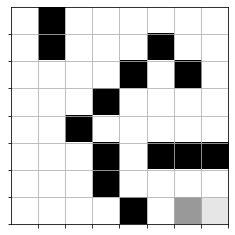

In [12]:
completion_check(model, qmaze)
show(qmaze)

This cell will test the model for one game. It will start the pirate at the top-left corner and run play_game. The agent should find a path from the starting position to the target (treasure). The treasure is located in the bottom-right corner.

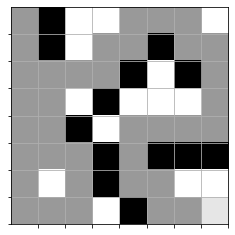

In [13]:
pirate_start = (0, 0)
play_game(model, qmaze, pirate_start)
show(qmaze)